# Guided mode expansion with Autograd

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## PhC cavity simulation

In this Notebook, we will optimize a photonic crystal cavity in a lithium niobate slab. We use the small-volume design of Minkov et al., APL 111 (2017), and optimize with respect to shifts in the positions of the air holes. So, we start by defining the starting structure, and a function that builds the photonic crystal given some hole shifts. The PhC parameters are as from Li et al., https://arxiv.org/abs/1806.04755 

In [2]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 10

# Regular PhC parameters
ra = 0.234
dslab = 0.4355
n_slab = 2.21

# Initialize a lattice and PhC
lattice = legume.Lattice([Nx, 0], [0, Ny*np.sqrt(3)/2])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Move the first two holes to create the L4/3 defect
xp[0] = 2/5
xp[1] = 6/5 
nc = len(xp)

# Initialize shift parameters to zeros
dx, dy = np.zeros((nc,)), np.zeros((nc,))

In [3]:
# Define L4/3 PhC cavity with shifted holes
def cavity(dx, dy):
    # Initialize PhC
    phc = legume.PhotCryst(lattice)
    
    # Add a layer to the PhC 
    phc.add_layer(d=dslab, eps_b=n_slab**2)
    
    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic] if yp[ic] == 0 else yp[ic] + dy[ic]
        xc = x if x == 0 else xp[ic] + dx[ic]
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
        if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
        if nx-1.6 > xp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
        if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
            phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))
            
    return phc

We will also define a function that initializes and runs a GME computation given shifts `dx`, `dy`, and returns the `gme` object and the quality factor of the fundamental cavity mode. 

In [4]:
# Solve for a cavity defined by shifts dx, dy
def gme_cavity(dx, dy, gmax, options):
    # Initialize PhC
    phc = cavity(dx, dy)
    
    # For speed, we don't want to compute the loss rates of *all* modes that we store
    options['compute_im'] = False
    
    # Initialize GME 
    gme = legume.GuidedModeExp(phc, gmax=gmax)
    
    # Solve for the real part of the frequencies
    gme.run(kpoints=np.array([[0], [0]]), **options)
    
    # Find the imaginary frequency of the fundamental cavity mode
    (freq_im, _, _) = gme.compute_rad(0, [Nx*Ny])
    
    # Finally, compute the quality factor
    Q = gme.freqs[0, Nx*Ny]/2/freq_im[0]
    return (gme, Q)

Let's first test the forward computation. Note that position shifts of the holes do not affect the average permittivity of the slab that is used for the guided modes. Thus, setting the `gradients` option to `approx` actually still returns the exact gradients, but is faster.

In [5]:
# Set some GME options
options = {'gmode_inds': [0], 'verbose': True, 'numeig': Nx*Ny+5, 'gradients': 'approx'}

# Run the simulation for the starting cavity (zero shifts as initialized above)
(gme, Q) = gme_cavity(dx, dy, 2, options)

10.1436s total time for real part of frequencies, of which
  0.2437s for guided modes computation using the gmode_compute='exact' method
  0.4994s for inverse matrix of Fourier-space permittivity
  6.7744s for matrix diagionalization using the 'eigh' solver
Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of selected eigenmodes


Cavity quality factor: 6454.17


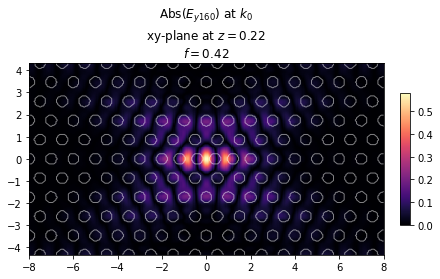

In [6]:
# Print the computed quality factor
print("Cavity quality factor: %1.2f" %Q)

# We can also visualize the cavity and the mode profile of the fundamental mode
ax = legume.viz.field(gme, 'e', 0, Nx*Ny, z=dslab/2, component='y', val='abs', N1=300, N2=200)

## Autograd backend

Now the real fun starts. We can use `legume` and `autograd` to efficiently compute gradients of GME simulations. Let's first define an objective function as the quality factor.

In [7]:
# To compute gradients, we need to set the `legume` backend to 'autograd'
legume.set_backend('autograd')

# Set GME options
gmax = 2
options = {'gmode_inds': [0], 'verbose': False, 'numeig': Nx*Ny+1, 'gradients': 'approx'}

# Define an objective function which is just the Q of the fundamental mode
def of_Q(params):
    dx = params[0:nc]
    dy = params[nc:]
    (gme, Q) = gme_cavity(dx, dy, gmax=gmax, options=options)
    
    # We put a negative sign because we use in-built methods to *minimize* the objective function
    return -Q

## Test gradient of quality factor

We will test the `legume` gradient vs. a numerical check. Note that `legume` (through `autograd`) computes the gradients efficiently, using one backpropagation to get the derivative of the objective w.r.t. *every* parameter simultaneously. Because of time considerations, for the numerical finite-difference check we will only pick one parameter at random.

In [8]:
# The autograd function `value_and_grad` returns simultaneously the objective value and the gradient
obj_grad = value_and_grad(of_Q)

# We choose one parameter index at random for the numerical check 
ind0 = np.random.randint(0, dx.size, 1)
# We set the starting parameters to zeros, i.e. un-modified cavity
pstart = np.zeros((2*nc, ))

# Compute the autograd gradients (NB: all at once!)
t = time.time()
grad_a = obj_grad(pstart)[1]
# Print the gradient w.r.t. the parameter index ind0
print("Autograd gradient:  %1.4f, computed in %1.4fs" %(grad_a[ind0], time.time() - t))

# Compute a numerical gradient for one selected index
t = time.time()
p_test = np.copy(pstart)
p_test[ind0] = p_test[ind0] + 1e-5 
grad_n = (of_Q(p_test) - of_Q(pstart))/1e-5
print("Numerical gradient: %1.4f, computed in %1.4fs" %(grad_n, time.time() - t))

print("Relative difference: %1.2e" %np.abs((grad_a[ind0] - grad_n)/grad_n))

Autograd gradient:  126.7622, computed in 21.0680s
Numerical gradient: 126.7591, computed in 22.1294s
Relative difference: 2.42e-05


The two gradients match very well, and the `autograd` simulation took as much time to get *all* the derivatives as it took the numerical simulation time to get just one of the derivatives. The magic of reverse-mode automatic differentiation!

## Test gradient of fields

We will also illustrate computing the gradient with respect to an objective function that depends on the electric field of a mode. We define an objective function as the inverse of the maximum field intensity of the mode, which gives the mode volume (up to some constants). Note that in `legume`, fields are normalized to integrate to unity by definition. 

In [9]:
# Define an objective function which is proportional to the V of the fundamental mode
def of_V(params):
    dx = params[0:nc]
    dy = params[nc:]
    (gme, Q) = gme_cavity(dx, dy, gmax=gmax, options=options)
    
    # Get the electric field in the center of the slab
    Ey = gme.get_field_xy('e', kind=0, mind=Nx*Ny, z=dslab/2, component='y', Nx=3, Ny=3)[0]['y']
    
    # Notice the use of autograd.numpy (npa) and not plain numpy (np)
    return 1/npa.square(npa.amax(npa.abs(Ey)))

In [10]:
# The autograd function `value_and_grad` returns simultaneously the objective value and the gradient
obj_grad = value_and_grad(of_V)

# We choose one parameter index at random for the numerical check 
ind0 = np.random.randint(0, dx.size, 1)
# We set the starting parameters to zeros, i.e. un-modified cavity
pstart = np.zeros((2*nc, ))

# Compute the autograd gradients (NB: all at once!)
t = time.time()
grad_a = obj_grad(pstart)[1][ind0]
print("Autograd gradient:  %1.4f, computed in %1.4fs" %(grad_a, time.time() - t))

# Compute a numerical gradient for one selected index
t = time.time()
p_test = np.copy(pstart)
p_test[ind0] = p_test[ind0] + 1e-5 
grad_n = (of_V(p_test) - of_V(pstart))/1e-5
print("Numerical gradient: %1.4f, computed in %1.4fs" %(grad_n, time.time() - t))

print("Relative difference: %1.2e" %np.abs((grad_a - grad_n)/grad_n))

//anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Autograd gradient:  0.1478, computed in 26.9183s
Numerical gradient: 0.1478, computed in 26.0712s
Relative difference: 4.53e-05


Note: the ComplexWarning comes from the way `autograd` implements `np.dot(A, B)` where `A` is real and `B` is complex. It can be disregarded, and as can be seen - the gradients are correct! 

## Quality factor optimization

The interesting thing about PhC cavities is that their Q can change dramatically upon small changes of the hole positions. On the other hand, the mode profile (and correspondingly the V) stay relatively unchanged. So, below we will optimize solely for the quality factor. Note that `legume` comes with a `Minimize` class that implements either `adam` or `lbfgs` minimization, which is what we are going to use. Of course, any external optimization function can also be combined with the gradient computation from `legume`. 

In [10]:
# Initialize an optimization object
opt = Minimize(of_Q)

# Starting parameters are the un-modified cavity
pstart = np.zeros((2*nc, ))

# Run an 'adam' optimization
(p_opt, ofs) = opt.adam(pstart, step_size=0.005, Nepochs=10, bounds = [-0.25, 0.25])

Epoch:    1/  10 | Duration:  17.06 secs | Objective: -6.454171e+03
Epoch:    2/  10 | Duration:  21.87 secs | Objective: -9.923204e+03
Epoch:    3/  10 | Duration:  19.18 secs | Objective: -1.614016e+04
Epoch:    4/  10 | Duration:  18.86 secs | Objective: -2.634488e+04
Epoch:    5/  10 | Duration:  19.77 secs | Objective: -3.837304e+04
Epoch:    6/  10 | Duration:  21.19 secs | Objective: -6.522123e+04
Epoch:    7/  10 | Duration:  20.65 secs | Objective: -9.175630e+04
Epoch:    8/  10 | Duration:  20.27 secs | Objective: -1.424177e+05
Epoch:    9/  10 | Duration:  21.38 secs | Objective: -2.015284e+05
Epoch:   10/  10 | Duration:  20.86 secs | Objective: -4.609610e+05


Note that the Q increased by almost two orders of magnitude in just 10 steps of the Adam optimization! Let's visuzlize the optimized cavity below.

Cavity quality factor: 460961.04


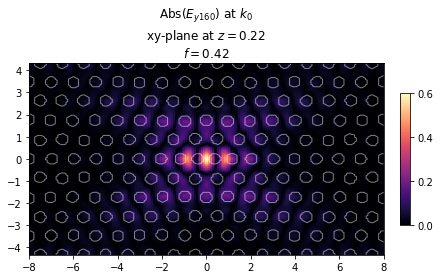

In [11]:
# Optimized parameters
dx = p_opt[0:nc]
dy = p_opt[nc:]

# Run the simulation
(gme, Q) = gme_cavity(dx, dy, gmax=gmax, options=options)
print("Cavity quality factor: %1.2f" %Q)
ax = legume.viz.field(gme, 'e', 0, Nx*Ny, z=dslab/2, component='y', val='abs', N1=200, N2=200)